## Comparison of different Optimizer choices with sin function
Available Optimizers: ["adaptive_gradient_descent", "adaptive_newton", "bfgs", "cmaes", "differential_evolution", "gradient_descent", "nlcg", "nelder_mead", "newton", "rprop"]


## Imports and dataset

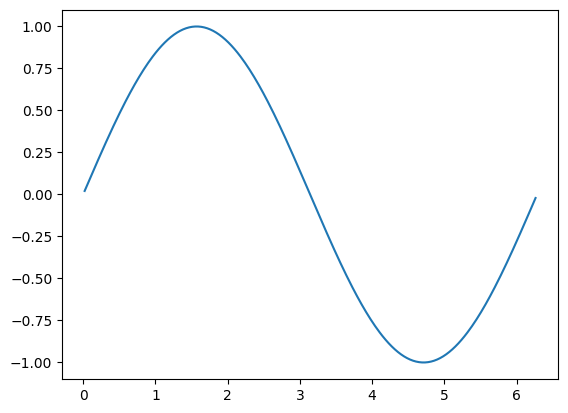

In [7]:
import HPO

import pysgpp

import sys

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import cross_val_score

import numpy as np
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasRegressor

import sklearn.metrics

import timeit

def to_standard(lower, upper, value):
    return (value-lower)/(upper-lower)


def from_standard(lower, upper, value):
    return value*(upper-lower)+lower

X = []
Y = []

num_samples = 300

for i in range(1, num_samples):
    X.append(2.0*math.pi/num_samples * float(i))
    Y.append(math.sin(2.0*math.pi/num_samples * float(i)))

plt.plot(X, Y)
plt.show()

X = torch.Tensor(X)
Y = torch.Tensor(Y)

X = X.reshape(-1, 1)

dataset = HPO.Dataset(X, Y)

BUDGET = 2
VERBOSE = 0
CV = 2
SCORING = 'neg_mean_squared_error'
TESTING = False

ITER = 10

BUDGETS = [i*10 for i in range(1, ITER+1)]

## Hyperparameterspace & Model & Function

In [8]:
hyperparameterspace = {
    'loss': ["list", 'binary_crossentropy', 'categorical_crossentropy', 'binary_crossentropy', 'mean_squared_error', 'mean_absolute_error'],
    'epochs': ["interval-int", 1, 400]
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste


##################### Function for sparse grid search #####################

class ExampleFunction(pysgpp.ScalarFunction):

    def __init__(self):
        super(ExampleFunction, self).__init__(2)


    def eval(self, x):
        index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
        loss = hyperparameterspace_special["loss"][index]
        epochs = int(from_standard(1, 400, x[1]))
        
        # Function to create model, required for KerasClassifier
        def create_model():
            # create model
            model = Sequential()
            model.add(Dense(10, input_shape=(1,), activation='relu'))
            model.add(Dense(20, activation='relu'))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(20, activation='relu'))
            model.add(Dense(10, activation='relu'))
            model.add(Dense(1, activation=None))
            # Compile model
            model.compile(loss=loss, optimizer='adam', metrics=['mean_squared_error'])
            return model

        model = KerasRegressor(model=create_model, verbose=0)

        # scores = cross_val_score(model, dataset.get_X(), dataset.get_Y(), cv=CV, scoring=SCORING)

        # return -scores.mean()

        model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs)

        if TESTING:
            Y_predicted = model.predict(dataset.get_X_test())
            return sklearn.metrics.mean_squared_error(dataset.get_Y_test().tolist(), Y_predicted)
        else:
            Y_predicted = model.predict(dataset.get_X_validation())
            return sklearn.metrics.mean_squared_error(dataset.get_Y_validation().tolist(), Y_predicted)
        


## Sparse grid search (Comparison of the optimizers)

In [9]:
available_optimizers = ["adaptive_gradient_descent", "adaptive_newton", "bfgs", "cmaes", "differential_evolution", "gradient_descent", "nlcg", "nelder_mead", "newton", "rprop"]

BUDGETS = [i*10 for i in range(1, ITER+1)]

TIMES = [[] for _ in range(len(available_optimizers))]
RESULTS = [[] for _ in range(len(available_optimizers))]
RESULTS_OPTIMIZED = [[] for _ in range(len(available_optimizers))]

for j in range(len(available_optimizers)):
    print("Current optimizer:", j, available_optimizers[j])

    sparse_params=[3, 0.95, available_optimizers[j]]

    BUDGET = 10
    for i in range(1, ITER+1):
        BUDGET = 10*i

        f = ExampleFunction()

        optimization = HPO.Optimization(dataset, f, hyperparameterspace, type="sparse", budget=BUDGET, verbosity=VERBOSE, sparse_params=sparse_params)

        starttime = timeit.default_timer()
        result = optimization.fit()
        endtime = timeit.default_timer()

        print(result)

        TESTING = True
        RESULTS[j].append(f.eval(result[0]))
        RESULTS_OPTIMIZED[j].append(f.eval(result[1]))
        TESTING = False

        TIMES[j].append(endtime - starttime)


Current optimizer: 0 adaptive_gradient_descent
Adaptive grid generation (Ritter-Novak)...


## Plotting

### Results (not optimized)

[[0.00023684531252947833], [0.0005663824473727264], [8.001671665175964e-05], [0.00020239335520373195], [2.3160281411803198e-05], [0.00022850465994851942], [0.00581772865478965], [0.000573912055455002], [0.0001312701451904393], [0.005581384189860433]]


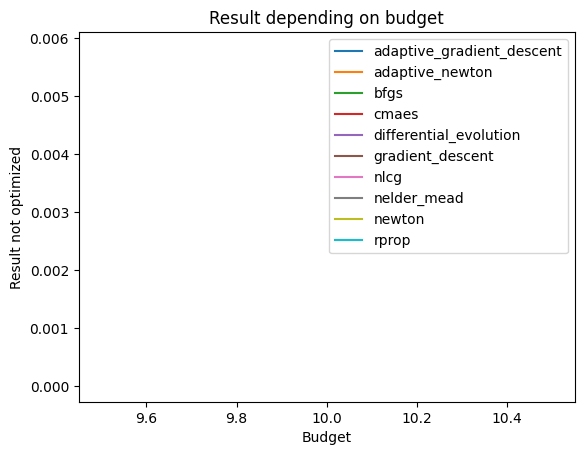

In [ ]:
print(RESULTS)

for i in range(len(available_optimizers)):
    plt.plot(BUDGETS, RESULTS[i], label = available_optimizers[i])

plt.xlabel('Budget')
plt.ylabel('Result not optimized')

plt.title('Result depending on budget')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

### Results (optimized)

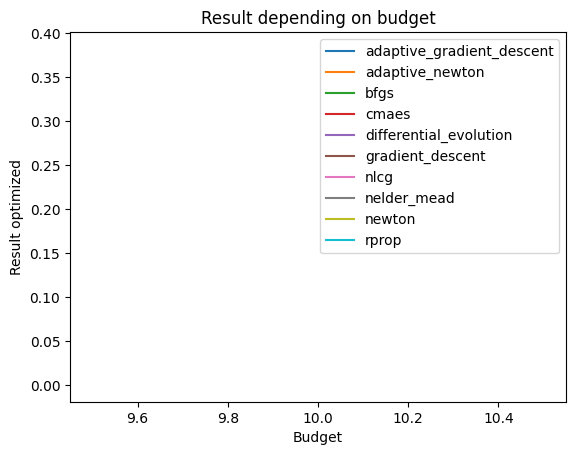

In [ ]:
for i in range(len(available_optimizers)):
    plt.plot(BUDGETS, RESULTS_OPTIMIZED[i], label = available_optimizers[i])

plt.xlabel('Budget')
plt.ylabel('Result optimized')

plt.title('Result depending on budget')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()

### Times

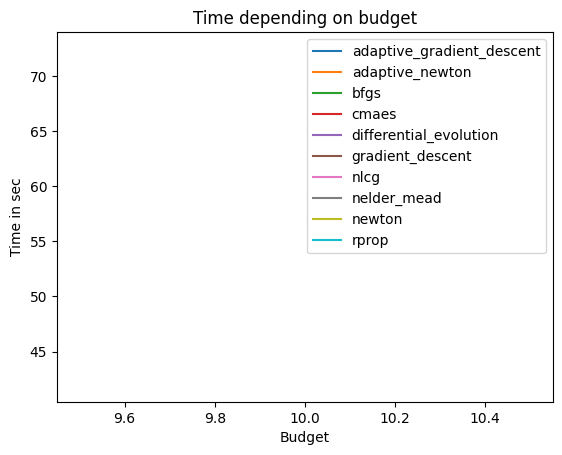

In [ ]:
for i in range(len(available_optimizers)):
    plt.plot(BUDGETS, TIMES[i], label = available_optimizers[i])

plt.xlabel('Budget')
plt.ylabel('Time in sec')

plt.title('Time depending on budget')
  
# show a legend on the plot
plt.legend()
  
# function to show the plot
plt.show()